# Interpolates TVD depths for Formation tops 
Based on a directional survey for wellbores

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb



### Import directional survey and formation tops from Excel file / fix variable names for a merge

In [4]:
# df1 = pd.read_excel ('/Users/davidadvocate/Documents/Python/Data/sE3 Survey.xlsx',
#                     sheet_name='Survey')
# df2 = pd.read_excel ('/Users/davidadvocate/Documents/Python/Data/sE3 Survey.xlsx',
#                     sheet_name='Tops')

# df2.rename(columns={"Depth_Ft": "Depth_FT"}, inplace=True)

In [10]:
# Read Excel XLSX files from Github

import requests
import io
from io import BytesIO

# Read sheets from XLSX file
# Note, You can not get the url path by clicking on "RAW" as with the CSV file, You'll have to know the sheet names
url = "https://raw.githubusercontent.com/dmadvoc/Petroleum-Geology-Analyses/main/sE3 Survey.xlsx"
download = requests.get(url).content
df1 = pd.read_excel(BytesIO(download), sheet_name='Survey') # This is a survey for 1 well
df2 = pd.read_excel(BytesIO(download), sheet_name='Tops')   # This well has four tops

df2.rename(columns={"Depth_Ft": "Depth_FT"}, inplace=True)

# Convert Depth_FT from float to integer for merge with df1
df2['Depth_FT']=df2['Depth_FT'].astype(int) 



### Merge and sort dataframes

In [17]:
# Examine Directions Survey (df1) and Formation Tops(df2) before merging
df1.info()
df2.info()
print(df2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Depth_FT  56 non-null     int64  
 1   TVD_FT    56 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.0 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   FM_Name   4 non-null      object
 1   Depth_FT  4 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 192.0+ bytes
  FM_Name  Depth_FT
0    F3WC      3429
1    MDDY      4021
2    MWRY      3747
3    THRM      4044


In [18]:
df3 = pd.merge(df1,df2, left_on='Depth_FT', right_on='Depth_FT', how='outer')

df3.sort_values(by=['Depth_FT'], inplace=True, ascending=True)
print(df3)

    Depth_FT       TVD_FT FM_Name
0          0     0.000000     NaN
1        315   314.412462     NaN
2        648   644.638959     NaN
3        955   950.562266     NaN
4       1003   998.456737     NaN
5       1035  1030.393592     NaN
6       1291  1285.171807     NaN
7       1354  1347.715519     NaN
8       1416  1409.112139     NaN
9       1456  1448.608692     NaN
10      1518  1509.406800     NaN
11      1549  1539.784466     NaN
12      1701  1685.896244     NaN
13      1737  1720.359746     NaN
14      1769  1750.928654     NaN
15      1824  1803.116834     NaN
16      1855  1832.356737     NaN
17      1886  1861.450020     NaN
18      1918  1891.403925     NaN
19      1950  1921.197712     NaN
20      1981  1949.960635     NaN
21      2013  1979.546109     NaN
22      2044  2007.931649     NaN
23      2076  2037.073526     NaN
24      2139  2094.401086     NaN
25      2202  2152.043545     NaN
26      2264  2208.858034     NaN
27      2643  2537.741141     NaN
28      2768  

### Calculate the True Vertical Depths for FM tops
Note: this code won't work if there are two tops between surounding survey TVD points

In [14]:
# Calculate MD above and below FM Top MD and determinte percent change for measured depth
df3['shift_dep'] = df3['Depth_FT'].shift(-1)
df3['shift_dep2']= df3['Depth_FT'].shift(1)
df3['del_shift_dep'] = df3['shift_dep'] - df3['shift_dep2']
df3['del_shift_dep2'] = df3['Depth_FT'] - df3['shift_dep2'] 
df3['pct_del_dep'] = (df3['del_shift_dep2'] / df3['del_shift_dep']) 

# Calculate the difference in TVD above and below the Top
df3['shift_tvd'] = df3['TVD_FT'].shift(-1)
df3['shift_tvd2']= df3['TVD_FT'].shift(1)
df3['del_shift_tvd'] = df3['shift_tvd'] - df3['shift_tvd2']

# Calculate the FM Tops Interpreted TVD for their MD
df3['interp_tvd'] = df3['shift_tvd2'] + df3['pct_del_dep'] * df3['del_shift_tvd']

# Output dataframe for FM Tops, Measured Depth and True Vertical Depth
out = df3[df3['FM_Name'].notna()]
out = out[['FM_Name', 'Depth_FT', 'TVD_FT' , 'interp_tvd']]
out['TVD_FT'] = out['interp_tvd']
out = out[['FM_Name', 'Depth_FT', 'TVD_FT']]

out

,FM_Name,Depth_FT,TVD_FT
56,F3WC,3429,3218.772556
58,MWRY,3747,3487.366460
57,MDDY,4021,3715.690487
59,THRM,4044,3734.770215


### Plot the results

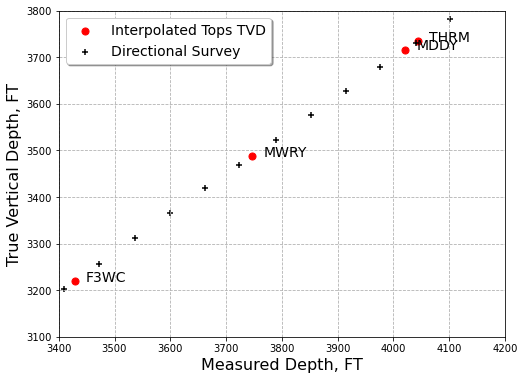

In [52]:
x=np.array(out['Depth_FT'])
y=np.array(out['TVD_FT'])
labels=np.array(out['FM_Name'])

fig=plt.subplots(figsize=(8,6))
plt.scatter(out['Depth_FT'], out['TVD_FT'], c='red', s=50, label ='Interpolated Tops TVD')
plt.scatter(df1['Depth_FT'], df1['TVD_FT'], c='k', marker='+', label='Directional Survey')

for i, txt in enumerate(labels):
    plt.annotate(txt, (x[i]+20, y[i]), fontsize=14)

plt.legend(shadow=True, fontsize=14)
plt.xlim(3400, 4200)
plt.ylim(3100, 3800)
plt.grid(linestyle='--')
plt.xlabel('Measured Depth, FT', fontsize=16)
plt.ylabel('True Vertical Depth, FT', fontsize=16)
plt.show()